# Environment set-up

In [1]:
%%capture
!pip install hazm
!pip install arabic_reshaper
!pip install python-bidi

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Crawl_tasnim_website/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Crawl_tasnim_website


In [3]:
import numpy as np

In [4]:
%%capture
## general python packages
import re
import pandas as pd
from pandas.core.indexers.utils import length_of_indexer
from tqdm.notebook import tqdm
tqdm.pandas()
from os import path
import ntpath
import numpy as np
## NLP packages
import gensim
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
from string import punctuation
import nltk
from hazm import *
from hazm import stopwords_list
from collections import Counter
from IPython.utils.py3compat import encode
import arabic_reshaper
from arabic_reshaper import reshape
from bidi.algorithm import get_display
## visualization packages
import seaborn as sns
import plotly.express as px

# Loading Data and get a brief overview of columns

In [5]:
df = pd.read_csv("News.csv" , encoding='utf-8')
print(f"Shape of my data: {df.shape}\n")
print(f"The number of null values for my data: \n{df.isnull().sum()}\n")
df=df.dropna()
print(f"Shape of my data after droping nulls: {df.shape}\n")
print(f"Number of duplicate text in `news` column of data: {df.shape[0] - df.drop_duplicates(subset=['news']).shape[0]}\n")
print("By hovering through data, this duplicates are the rows that our request to website got time out error \n")
df.drop_duplicates(subset=["news"], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f"shape of data after dropping duplicate rows: {df.shape}\n")
print(f"colum's type of data : \n{df.dtypes}\n")

Shape of my data: (20, 3)

The number of null values for my data: 
title      0
summery    0
news       4
dtype: int64

Shape of my data after droping nulls: (16, 3)

Number of duplicate text in `news` column of data: 9

By hovering through data, this duplicates are the rows that our request to website got time out error 

shape of data after dropping duplicate rows: (7, 3)

colum's type of data : 
title      object
summery    object
news       object
dtype: object



# Preprocessing and EDA

**Preprocessing Steps**
- First we normalize the news column. by normalizing I mean transform data into more human readble form and we do minimum removal on texual features. this include fixing spaces around punctuations, remove stop words, remove new line characters and etc.

In [6]:
class TextPreprocessing():
    """Class for preprocessing text data."""

    def __init__(self):
        self.normalizer = Normalizer()
        self.stemmer = Stemmer()
        self.lemmatizer = Lemmatizer()

    def weird_patterns(self, data):
        weird_pattern = re.compile(
          "["
          u"\U0001F600-\U0001F64F"  # emoticons
          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
          u"\U0001F680-\U0001F6FF"  # transport & map symbols
          u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
          u"\U00002702-\U000027B0"
          u"\U000024C2-\U0001F251"
          u"\U0001f926-\U0001f937"
          u'\U00010000-\U0010ffff'
          u"\u200c"
          "]+", flags=re.UNICODE)
        return [weird_pattern.sub(r'', sent ) for sent in data]

    def normalize(self, news):
      return [(self.normalizer.normalize(new))for new in news]

    def sent_to_words(self, sentences):
      for sentence in sentences:
          yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def lemma(self, texts):
      return [[(self.lemmatizer.lemmatize(word))for word in text]for text in texts]

    def remove_stop_words(self, words):
      return [[token for token in word if token not in stopwords_list()]for word in words]


In [7]:
def column(text):
    data_normal = list(TP.normalize(text))
    clean_news = TP.weird_patterns(data_normal)
    data_words = list(TP.sent_to_words(clean_news))
    data_stop_words = list(TP.remove_stop_words(data_words))
    data_lemma = list(TP.lemma(data_stop_words))
    return data_lemma

In [8]:
TP = TextPreprocessing()
##Preprocessing on the news column
df['tokens_news'] = [" ".join(x) for x in column(df['news'].tolist())]
##Preprocessing on the summery column
df['tokens_sum'] = [" ".join(x) for x in column(df['summery'].tolist())]
##Preprocessing on the title column
df['tokens_title'] = [" ".join(x) for x in column(df['title'].tolist())]

In [9]:

#Function for plotting
def plotting(data):
      corpus=[]
      new= data.str.split()
      new=new.values.tolist()
      corpus=[word for i in new for word in i]
      counter=Counter(corpus)
      most=counter.most_common()

      x, y, t= [], [], []
      for word,count in most[:5]:
              x.append(word)
              y.append(count)
              t = x,y
      x1=[get_display(reshape(label)) for label in x]
      return sns.barplot(x=y,y=x1) , print(f"{x}\n{y}") , t


['استقلال', 'تیم', 'شرایط', 'باشگاه', 'بازیکن']
[43, 19, 17, 16, 16]


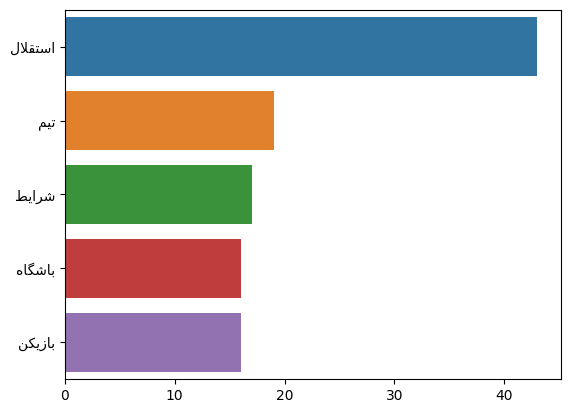

In [10]:
#Ploting News and save
t_news =plotting(df['tokens_news'])
plt.savefig('News Text Word Count Distribution.png')

['تیم', 'فوتبال', 'استقلال', 'ابیپوشان', 'شرایط']
[7, 6, 5, 4, 3]


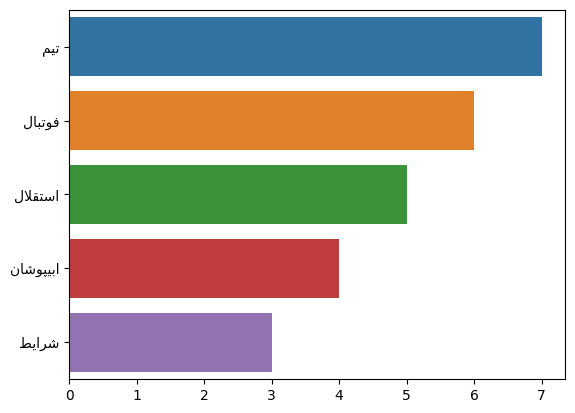

In [11]:
#Ploting summery of  News and save
t_sum = plotting(df['tokens_sum'])
plt.savefig('Summery Text Word Count Distribution.png')

['استقلال', 'هوادار', 'نکونام', 'میزبان', 'لیگ']
[6, 2, 2, 2, 2]


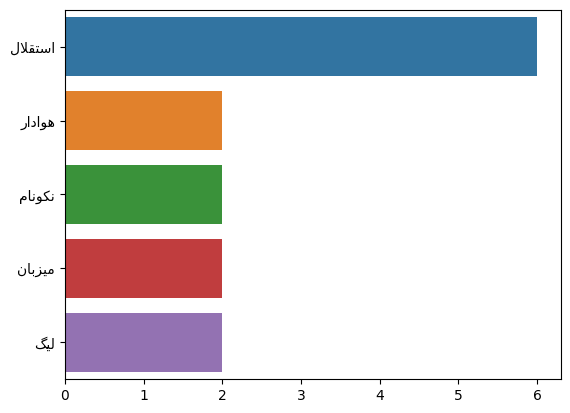

In [12]:
#Ploting title of  News and save
t_title =plotting(df['tokens_title'])
plt.savefig('Title Text Word Count Distribution.png')

In [17]:
#Groupup most words in dataset
t_total = []
t_total_title =t_title[2][0] + t_news[2][0] + t_sum[2][0]
t_total_count =t_title[2][1] + t_news[2][1] + t_sum[2][1]
plotdata = pd.DataFrame({
    'title' :t_total_title,
    'count' :t_total_count
})
df_grouped=plotdata[['title','count']].groupby(by='title').agg(lambda x: x)
p=[]
for i in range(len(df_grouped['count'])):
    array = np.array(df_grouped['count'][i])
    total = np.sum(array)
    p.append(total)

title_name =plotdata["title"].drop_duplicates()

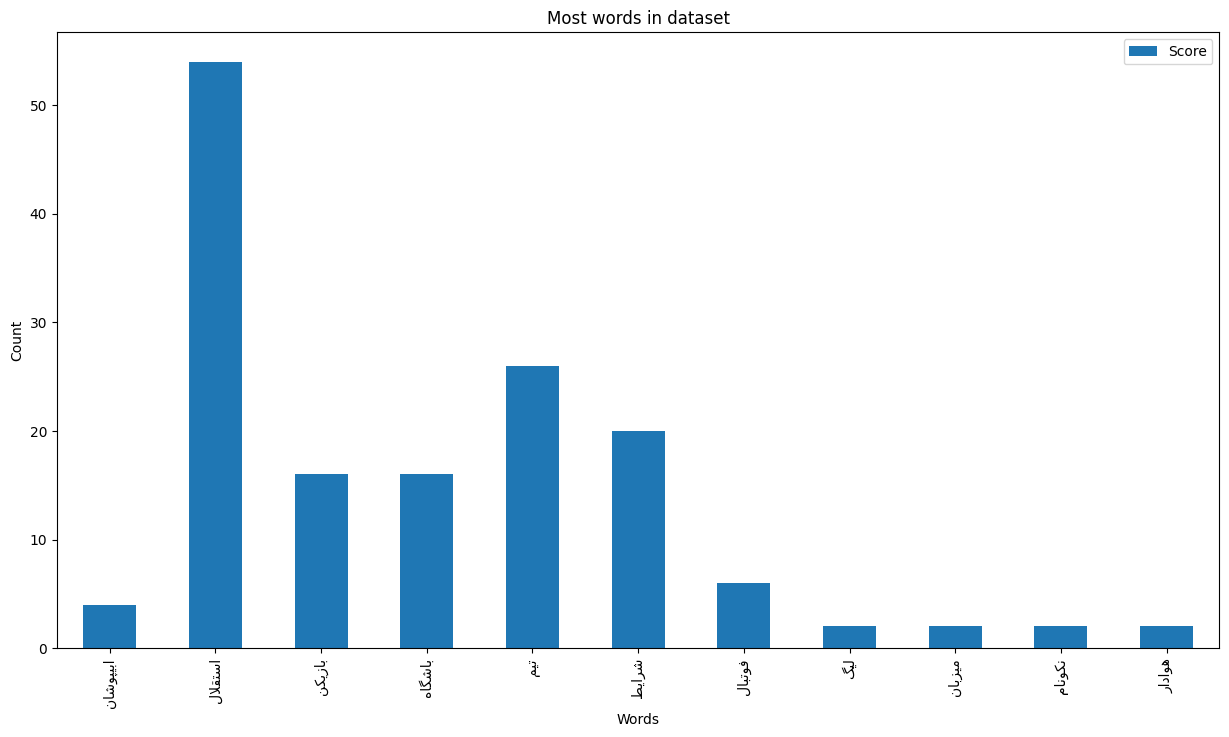

In [18]:
#Ploting Most words in dataset
plotdata = pd.DataFrame({
    "Score":p},
    index=[get_display(reshape(label)) for label in sorted(title_name)])

plotdata.plot(kind="bar",figsize=(15, 8))
plt.title("Most words in dataset")
plt.xlabel("Words")
plt.ylabel("Count")

plt.savefig('Text Word Count in dataset.png')

# Conclusions
- As we can see, most of the words in our dataset is about Sport.
- So by scraping through the website we understand this website about sport news
- By looking deeper, most of the news about football and particularly about Esteghlal team